# Higher-order Markov chains

In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype
from numpy.random import normal

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Markov chains with a complex state space

Before going into technical details of higher-order Markov chains let us consider a **really crude** model of disease spead where the state is determined by the multiplicative constant $\alpha_i$ and total count of infected patients $x_i$.
Let the corresponding update rule for the count be
\begin{align*}
x_{i+1}=\alpha_i\cdot x_i + x_i\cdot\mathcal{N}(0,\delta) 
\end{align*}
where the first term models exponential growth and the second term models random fluctuations in the process. 
The choice of the noise term is done based on simplicity and does not refect reality very well.

The multiplicative factor $\alpha_i$ depends on the spread of the disease. Let us have the following deterministic update rule

\begin{align*}
\alpha_{i+1}=
\begin{cases}
1.3 &\text{if } 0< x_i\leq 100,\\
1.2 &\text{if } 100 < x_i\leq 1000 \text{ and } \alpha_i > 0.95\\
0.95 &\text{if } 100 < x_i\leq 1000 \text{ and } \alpha_i= 0.95\\
0.95 &\text{if } 1000< x_i 
\end{cases}
\end{align*}

which models the reaction of the society to the disease spread.    

In [3]:
def update(state):
    x = state[0] * state[1] + state[1] * normal(0, 0.1)
    if state[1] <= 100:
        alpha = 1.3
    elif state[1] <= 1000 and state[0] > 0.95:
        alpha = 1.2
    elif state[1] <= 1000 and state[0] == 0.95:
        alpha = 0.95
    else:
        alpha = 0.95
    return (alpha, x)

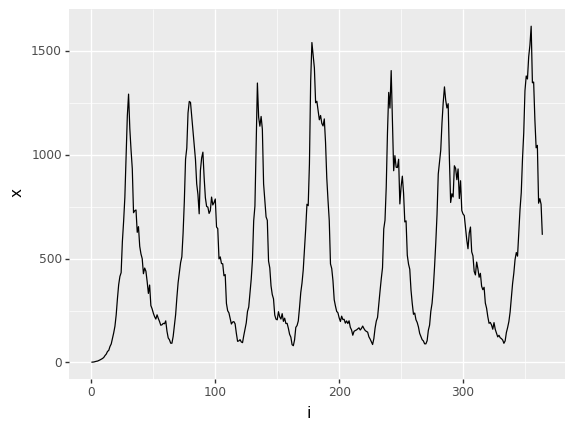

<ggplot: (-9223372029837186167)>

In [4]:
n = 365
state=[1.3, 1] 
obs = DataFrame({'i':range(n), 'alpha': [0]*n, 'x': [0]*n})
for i in range(n):
    state = update(state)
    obs.iloc[i,1:]=state

# Visualisation    
head(obs)
ggplot(obs) + geom_line(aes(x = 'i', y = 'x'))

## II. Higher-order Markov chains

The previous example highlighted that the state space does not have to be a single observation and nor do the update rules have to be identical for different substates. 
Let us now return to the language modelling. 

The assumption that the next letter depends only on the current letter is obviously wrong. We could do much better if we could choose the letter based on two previous letters. To model this as a Markov chain:
* Let the state $s_{i-1}$ be the pair of last two characters $(x_{i-1}, x_{i})$. 
* In particular, let the first two letter be be the first state $s_1=(x_1, x_2)$ and the correspondind initial probability is 
\begin{align*}
\Pr[s_1=(x_1,x_2)]=\beta[x_1,x_2]
\end{align*}
if we flatten vector into two-dimensional array. 


* The update rule for the first component is determnistic
  \begin{align*}
   s_{i+1}[0]=s_i[1]
  \end{align*}
* The probabilistic update for the next symbol can now indeed use two last characters  
  \begin{align*}
   \Pr[s_{i+1}[1]=x_{i+2}|s_{i}]=\Pr[x_{i+2}|x_{i}, x_{i+1}]=\alpha[x_{i}, x_{i+1}, x_{i+2}]
  \end{align*}
  when we flatten the matrix into array with three columns

### Training

One can show that the maximum likelihood and maximum aposteriory estimates for the initial and transition probabilities can be estimated form trigram counts.
The derivation is completely analogous to the treatment of the standard Markov chain.
Maximum likelihood estimates are

\begin{align*}
\beta[u_1, u_2]  &= \frac{k(\bullet,u_1, u_2)}{k(\bullet,*, *)}\\
\alpha[u_1 u_2, u_3] &= \frac{k(u_1,u_2, u_3)}{k(u_1,u_2,*)}
\end{align*}

Laplace smoothing estimates

\begin{align*}
\beta[u_1, u_2]  &= \frac{k(\bullet,u_1, u_2)+c}{k(\bullet,*, *)+m^2c}\\
\alpha[u_1 u_2, u_3] &= \frac{k(u_1,u_2, u_3)+c}{k(u_1,u_2,*)+mc}
\end{align*}

where $\bullet$ denotes the start of the string, $c\geq 0$ is the Laplace smoothing constant and $m$ is the total number of characters. 

### Generalisation to any order

The number of remembered character does not have to be two it can be extended to any fixed number of characters. The entire treatment is completely analogous. 
However the number of parmeters in the model grows with each additional character.
As a result, we need much more data to train the model!


# Homework

## 2.1 Finding parameters for the higher-order Markov chain  (<font color='red'>1p +1p</font>)

Find $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ parameters for the second and third order Markov chains for language modelling. Train the datasets on `est_training_set.csv` and `eng_training_set.csv` in the directory `data` to learn model parameters.
Use Laplacian smoothing. What is the proportion of entries that would be zero if we use maximum likelihood model. 

More generaly let the support for the coefficient be the number of observations in the denominator. Draw the graph where $y$-axis shows the proportion of coefficients that are have support less or equal to $x$. Interpret the result. Why is it problematic if the coefficient has low support? (<font color='red'>1p</font>)

Build language detectors base on the higher-order Markov chains and repeat the classification experiment done in the [exercise 1.3](./01_markov_chains.ipynb) and compare the results (<font color='red'>1p</font>). 

## 2.2 Function for imputing missing characters (<font color ='red'>1p</font>)

Train a second order Markov model on the same dataset as before define a function `impute_characters_3(x:str)` that imputes missing characters in words using belief propagation and outputs the figure showing marginal posterior distributions for each location together with the maximum aposteriori estimate.
Test it on four different words with missing characters and compare its output with a previous imputing functions defined in [exercises 1.1 and 1.2](./01_markov_chains.ipynb). It is sufficient to compare it with one of those functions. 

**Hint:** 
As a result, you can reuse the belief propagation code for Markov chains. 
You only have to look how the beliefs and transition proabilities are shaped and how you need to marginalise posteriors computed for individual states.



### Example commands for manipulating multidimensional arrays

In [5]:
pi = DataFrame({'u1':['a','a','b','b'], 'u2': ['a', 'b', 'a','b'], 'pr':[0.1, 0.2, 0.3, 0.4]})
display(pi)

alpha = DataFrame({'u1': ['a','a','a','a','b','b','b','b'], 
           'u2': ['a','a','b','b','a','a','b','b'], 
           'u3': ['a','b','a','b','a','b','a','b'], 
           'pr': [.1, .9, .3, .7, .5, .5, .8, .2]})
display(alpha)

,u1,u2,pr
0,a,a,0.1
1,a,b,0.2
2,b,a,0.3
3,b,b,0.4


,u1,u2,u3,pr
0,a,a,a,0.1
1,a,a,b,0.9
2,a,b,a,0.3
3,a,b,b,0.7
4,b,a,a,0.5
5,b,a,b,0.5
6,b,b,a,0.8
7,b,b,b,0.2


To apply the $\alpha$ transformation to the vector $\pi$ we need to reshape $\alpha$ into a matrix with matching order of rows.

In [6]:
pi = (pi
      .set_index(['u1','u2'])
      .sort_index())

alpham = (alpha
         .set_index(['u1','u2','u3'])
         .unstack(['u3'])
         .pipe(reset_column_index, 0)
         .sort_index())

mdisplay([pi.reset_index(),alpham.reset_index()], ['pi', 'alpha'])

pi alpha 
 
 
 u1 
 u2 
 pr 
 
 
 
 
 a 
 a 
 0.1 
 
 
 a 
 b 
 0.2 
 
 
 b 
 a 
 0.3 
 
 
 b 
 b 
 0.4 
 
 
 
 
 
 u3 
 u1 
 u2 
 a 
 b 
 
 
 
 
 
 a 
 a 
 0.1 
 0.9 
 
 
 
 a 
 b 
 0.3 
 0.7 
 
 
 
 b 
 a 
 0.5 
 0.5 
 
 
 
 b 
 b 
 0.8 
 0.2

The following three options give the desired result. The last result is type safe. 

In [7]:
display(np.dot(pi['pr'].values, alpham.values))
display(np.dot(pi.T.values, alpham.values))
pi.T.dot(alpham)

array([0.54, 0.46])

array([[0.54, 0.46]])

u3,a,b
pr,0.54,0.46


Note that this operation provides probabilities for the next symbol $u_3$ while the previous symbol is forgotten.
Thus this transformation is not enough to compute desired probabilities.
We need to modify $\alpha$ so that the previous symbol is not forgotten.

In [8]:
alpham = (alpha
          .assign(u2_new = lambda df: df['u3'], u1_new = lambda df: df['u2'])
          .set_index(['u1','u2', 'u1_new', 'u2_new'])
          .sort_index()
          [['pr']]
          .unstack(['u1_new', 'u2_new'], fill_value=0)
          .pipe(reset_column_index, 0)
         )
alpham

u1_new    a         b     
u2_new    a    b    a    b
u1 u2                     
a  a    0.1  0.9  0.0  0.0
   b    0.0  0.0  0.3  0.7
b  a    0.5  0.5  0.0  0.0
   b    0.0  0.0  0.8  0.2

In [9]:
display(np.dot(pi['pr'].values, alpham.values))
display(np.dot(pi.T.values, alpham.values))
pi.T.dot(alpham).T

array([0.16, 0.24, 0.38, 0.22])

array([[0.16, 0.24, 0.38, 0.22]])

pr
u1_new u2_new      
a      a       0.16
       b       0.24
b      a       0.38
       b       0.22